# Clean cattle data

This notebook contains the blocks of code for cleaning cattle data for the visual cattle weight project. </br>

</br>
This noebook walks through the process of cleaning the data. Some blocks of code need not be run every time data is added to the database. </br>
For example, the "Fill Missing Data" section was only intended to fill the data that was missing from an early version of the collection program.</br>
Also, sections at the end, "Functions for Handling the Dataset" and "Exploring the Data" are extra exploritory code blocks. 


### Table of Contents

* [Setup](#setup)
    * [Imports](#imports)
    * [Load Data](#loads)
    * [Save Dataset](#save)
    
* [Data Cleaning](#cleaning)
    * [Fill Missing Data](#fill)
        * [Combine original dataset with offline predictions](#combpred)
        * [Fill Missing Lot Numbers](#filllot)
        * [Fill Missing Timestamps](#filltime)
        * [Fill Missing Auction Labels](#fillauction)
    * [Clean Numerical Data](#cleannum)
* [Correcting Data Timing](#correcttime)
    * [Explore Data Correlation](#expcorr)
    * [Add Aggrigate Metrics](#addaggmet)
    * [Adjust Timing](#adjusttime)
    * [View Corrected Timing](#viewtime)
* [Extract Useful Data](#extractuseful)
* [Funcitons for Handling the Dataset](#functions)
    * [Handling Pictures](#pictures)
* [Exploring the Data](#exploring_data)

# Setup <a class="anchor" id="setup"></a>

Note:
>The DATABASE_LOCATION is the address to a shortcut which points to the external drive containing the data.<br>
>This is a work-around since Jupyter does not support accessing files from another drive.

In [1]:

DATABASE_LOCATION = 'E:/cattle_data'
INPUT_PATH = DATABASE_LOCATION+'/img'
OUTPUT_PATH = DATABASE_LOCATION+'/training'
DATASET = 'cattle_data.json' #data will be read from this file if COMBINE_DATA_FILES is False
COMBINE_DATA_FILES = True
USE_GPU = False

### Imports <a class="anchor" id="imports"></a>

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"

if USE_GPU:
    os.environ["CUDA_VISIBLE_DEVICES"]='0'
else:
    os.environ["CUDA_VISIBLE_DEVICES"]="-1" 
    
import tensorflow as tf
import pandas as pd
import json
from yolo import Predictor
from time import time
import datetime as dt
import cv2
import numpy as np
from multiprocess import  Pool
from matplotlib import pyplot as plt
import PIL.Image
from IPython.display import display
from io import BytesIO
import datetime
import ipywidgets as widgets
from ipywidgets import *
import warnings
from tqdm.notebook import tqdm, trange

### Load Data <a class="anchor" id="loads"></a>

The database is structured as follows:

<div class="note structure">
<pre>-> cattle_data</pre> 
<pre style="margin-left: 30px">- {auction}_{date}_{ext}_.json </pre>
<pre style="margin-left: 30px">- im_id_{auction}.txt </pre>
<pre style="margin-left: 30px">-> img </pre>
<pre style="margin-left: 60px">-> {auction} </pre>
<pre style="margin-left: 90px">- im_{id}.png </pre>
<pre style="margin-left: 30px">-> training </pre>
<pre style="margin-left: 60px">-> singles </pre>
<pre style="margin-left: 90px">- {auction}_{lotnum}_{id}.png </pre>
<pre style="margin-left: 60px">-> two_views </pre>
<pre style="margin-left: 90px">- {lotnum}_{pairnum}_{id}_end.png </pre>
<pre style="margin-left: 90px">- {lotnum}_{pairnum}_{id}_side.png </pre>
<pre style="margin-left: 60px">- training.json </pre>
<pre style="margin-left: 60px">- two_view_training.json </pre>
</div>
</br>
Where the raw data is stored in the base "img" folder. Once the data is cleaned, it is stored in the "training" directory.

In [3]:
f_names = []

if COMBINE_DATA_FILES:
    f_names = []
    for name in os.listdir(DATABASE_LOCATION):
        if name.endswith('.json'):
            f_names.append(name)
else:
    f_names.append(DATASET) 

frame = []
#load the dataset
with open(os.path.join(DATABASE_LOCATION, f_names.pop()), 'r') as file:
        frame = json.load(file)

# add any other datasets in the folder
for name in f_names:
    with open(os.path.join(DATABASE_LOCATION, name), 'r') as file:
        frame.extend(json.load(file))

df = pd.DataFrame(frame)
    
print('Found {} files.'.format(len(f_names)))
print('Loaded {} datapoints!'.format(len(df)))

Found 117 files.
Loaded 833644 datapoints!


In [4]:
#Load the predictor model
predictor = Predictor('C:/users/derek/Documents/nets/yolov3.weights', obj_thresh=0.01)

## Save Dataset <a class="anchor" id="save"></a>

In [5]:
date = dt.datetime.strftime(dt.datetime.now(), '%Y-%m-%d')
save_name = f'Combined_{date}.json' # to save in archives add "archived/" to the name
dataframe = df

with open(os.path.join(DATABASE_LOCATION, save_name), 'w') as file:
    df_to_save = dataframe.to_json(orient="records")
    parsed = json.loads(df_to_save)
    json.dump(parsed, file)

# Data Cleaning  <a class="anchor" id="cleaning"></a>

## Fill Missing Data  <a class="anchor" id="fill"></a>

### Combine original dataset with offline prediction  <a class="anchor" id="combpred"></a>

In [61]:
with open(os.path.join(DATABASE_LOCATION, 'predicted_cattle.json'), 'r') as file:
        frame = json.load(file)
pred = pd.DataFrame(frame)

In [62]:
# join with prediction
jdf = df.join(pred.set_index('IMG_ID'), on='IMG_ID', rsuffix='_new')

In [68]:
jdf.prediction = jdf.prediction_new
jdf.drop(columns=['prediction_new'], inplace=True)

### Fill Missing Lot Numbers  <a class="anchor" id="filllot"></a>
Missing lot numbers are given a unique identifier by combining the Total_Weight and the Type

In [64]:
jdf.lot.fillna(value=jdf.Type+' '+jdf.Tot_Weight, inplace=True)

In [74]:
jdf.head()

,IMG_ID,Type,Shrink,Age,Avg_Weight,Tot_Weight,Hauled,Weaned,Feed,Health,Timestamp,img_has_cow,lot,prediction,auction
1,21707,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:26,True,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.056863133', 'Box'...",NaN
2,21708,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:29,True,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.98009366', 'Box':...",NaN
3,21709,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:32,False,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.019672241', 'Box'...",NaN
3,21709,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:32,False,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.019672241', 'Box'...",NaN
3,21709,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:32,False,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.019672241', 'Box'...",NaN


### Fill Missing Timestamps <a class="anchor" id="filltime"></a>
Date/time information is collected from the 'modified time' property of the associated image file. 

In [59]:
# Get time stamp from image #don't need this once all data is time stamped 
def get_time_stamp(im_id):
    time_stamp = os.stat('{}/im_{}.png'.format(INPUT_PATH, im_id)).st_mtime
    return datetime.datetime.fromtimestamp(time_stamp).strftime('%Y-%m-%d-%H:%M:%S.%f')

# Add time stamp column to dataset
df['Timestamp'] = df.IMG_ID.apply(get_time_stamp)

### Fill Missing Auction Labels  <a class="anchor" id="fillauction"></a>
Missing auction labels are filled by finding the day of week and then replacing that number with the auciton name that was running on that day. 

In [79]:
jdf.auction.fillna(value=pd.to_datetime(jdf.Timestamp).dt.day_of_week, inplace=True)
jdf.auction.replace(1, 'rimbey', inplace=True)
jdf.auction.replace(2, 'ponoka', inplace=True)
jdf.auction.replace(3, 'westlock', inplace=True)
jdf.auction.replace(4, 'dawson_creek', inplace=True)

In [85]:
jdf.head()

,IMG_ID,Type,Shrink,Age,Avg_Weight,Tot_Weight,Hauled,Weaned,Feed,Health,Timestamp,img_has_cow,lot,prediction,auction
1,21707,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:26,True,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.056863133', 'Box'...",rimbey
2,21708,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:29,True,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.98009366', 'Box':...",rimbey
3,21709,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:32,False,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.019672241', 'Box'...",rimbey
3,21709,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:32,False,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.019672241', 'Box'...",rimbey
3,21709,8 RMX STEER,3,,725,5801,9 MILES,,CHOPPED HAY & STRAW-3 WEEKS,8 WAY-MAY 30/2021/ NO IMPLANTS/ NO ANTIBIOTICS...,2021-11-10-12:00:32,False,8 RMX STEER 5801,"[{'Label': 'cow', 'Prob': '0.019672241', 'Box'...",rimbey


In [88]:
print(len(jdf))
jdf.drop_duplicates(subset=['IMG_ID'], inplace=True)
len(jdf)

42045


<ipython-input-88-279de0d32b29>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  jdf.drop_duplicates(subset=['IMG_ID'], inplace=True)


42030

## Clean Numerical Data  <a class="anchor" id="cleannum"></a>

In [5]:
# Removing commmas from thousands place
df.Avg_Weight = df["Avg_Weight"].str.replace(",","")
df.Tot_Weight = df["Tot_Weight"].str.replace(",","")

In [6]:
df.Avg_Weight[df.Avg_Weight.str.endswith('lbs')]

145       435lbs
146       435lbs
147       435lbs
148       435lbs
149       435lbs
           ...  
831941    903lbs
831942    903lbs
831943    903lbs
831944    903lbs
831945    903lbs
Name: Avg_Weight, Length: 270047, dtype: object

In [7]:
# remove any 'lbs' suffixes from Avg_Weight and Total_Weight columns
def remove_lbs(s):
    if s.endswith('lbs'):
        return s[:-3]
    elif s.endswith('LBS'):
        return s[:-3]
    else:
        return s

df.Avg_Weight = df.Avg_Weight.apply(remove_lbs)
df.Tot_Weight = df.Tot_Weight.apply(remove_lbs)

In [8]:
# replace blank weights with 0's
def rep_blank(w):
    w = str(w)
    if w=='' or w.endswith('RANGE') or w.startswith('RANGE'):
        w = '0'
  
    w = w.replace(',','')
    w = w.replace(' BASE','')
    w = w.replace('BASE ','')
    w = w.replace('825 825', '825')

    return float(w)  
df.Avg_Weight = df.Avg_Weight.apply(rep_blank)
df.Tot_Weight = df.Tot_Weight.apply(rep_blank)

In [9]:
def fix_time(t):
    if t.find('.') == -1:
        return t + '.00'
    else:
        return t
    
df.Timestamp = df.Timestamp.apply(fix_time)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833644 entries, 0 to 833643
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   lot         833644 non-null  object 
 1   IMG_ID      833644 non-null  object 
 2   Type        833644 non-null  object 
 3   Shrink      833644 non-null  object 
 4   Age         833644 non-null  object 
 5   Avg_Weight  833644 non-null  float64
 6   Tot_Weight  833644 non-null  float64
 7   Hauled      833644 non-null  object 
 8   Weaned      833644 non-null  object 
 9   Feed        833644 non-null  object 
 10  Health      833644 non-null  object 
 11  Timestamp   833644 non-null  object 
 12  prediction  833235 non-null  object 
 13  auction     833644 non-null  object 
dtypes: float64(2), object(12)
memory usage: 89.0+ MB


In [11]:
df.Timestamp = pd.to_datetime(df['Timestamp'], format ='%Y-%m-%d-%H:%M:%S.%f')

### Adjusting Prediction Thresholds
Since the prediction column includes predictions with a probability down to 1%, we can set an alternative threshold for the probability of the has_cow column.
From observation of the predicted data, we can tell that the threshold needs to be different for each auction location. Included in the following function is a filter customizeing the threshold for each auction.</br>
The thresholds that are set for each auction location are as follows:
   * Rimbey : 
   * Westlock : 
   * Ponoka : 7.5%
   * Dawson Creek : 1%
   * Beaverlodge : 
    
</br></br>
We need to add an aditional filter to the Ponoka auction data. In the following image we can see a prediction of a cow in the preliminary pen with 61% probability. This is undesired data since it is not in the viewing pen. We can remove this data by providing an upper bound for the lower edge of the bounding box. Any bounding box where the bottom is higher than the bottom of the fence will be filtered out. 
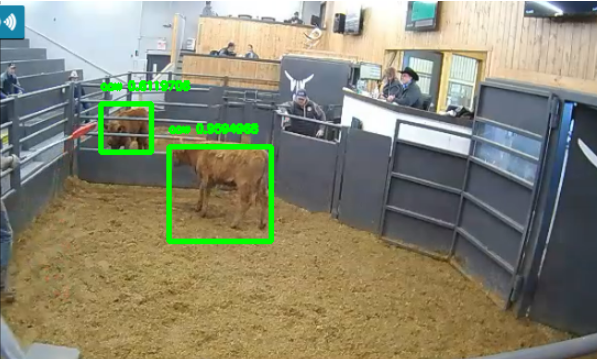

In [12]:
i = 0
err = 0
pbar = tqdm(total=len(df))

def adj_pred(d):
    global i, err
    thresh = 0.01
    i+=1
    
    def box_filter_gt(box, coord, thresh):
        val_1, val_2 = coord
        return box[val_1][val_2] > thresh
    
    #print(u_predict)
    try:
        if len(d.prediction) < 1:
            return d.prediction
        elif d.prediction[0]=='IMAGE_ERROR':
            err += 1
            return d.prediction

        u_predict = pd.DataFrame(d.prediction)
       
        if d.auction=='ponoka':
            thresh = 0.075
            bbox_thresh = 173
            
            # include positional threshold to avoid including cows that are not in the ring
            u_predict = u_predict[u_predict.Box.apply(box_filter_gt, args=(('y', 1), bbox_thresh))]
            u_predict = u_predict[u_predict.Prob.astype(float) > thresh]
            return u_predict

        elif d.auction=='dawson_creek':
            thresh = 0.05

        elif d.auction=='westlock':
            thresh = 0.155

        elif d.auction=='beaverlodge':
            thresh = 0.1

        elif d.auction=='rimbey':
            thresh = 0.1
    
        
        # filter by Probability threshold
        u_predict = u_predict[u_predict.Prob.astype(float) > thresh]
        
        pbar.update(1)
    except Exception as ex:
        print(d)
        print(d.prediction)
        raise ex
    return u_predict

df['adj_prediction'] = df.dropna().apply(adj_pred, axis=1)
print('err = '+str(err))

  0%|          | 0/833644 [00:00<?, ?it/s]

err = 301


### Remove data by frequency

In [13]:
# removes old data that had low time resolution
min_time = 2
df = df[(df.Timestamp.diff().dt.seconds < min_time) | (df.Timestamp.diff().dt.seconds > 8)]

In [14]:
len(df)

792535

### Drop Data with no Images 

In [15]:
# return a boolean of image existance
def has_image(img_id):
    if os.path.exists('{}/{}/im_{}.png'.format(INPUT_PATH, 'rimbey',img_id)):
        return True
    if os.path.exists('{}/{}/im_{}.png'.format(INPUT_PATH, 'dawson',img_id)):
        return True
    if os.path.exists('{}/{}/im_{}.png'.format(INPUT_PATH, 'westlock',img_id)):
        return True
    if os.path.exists('{}/{}/im_{}.png'.format(INPUT_PATH, 'ponoka',img_id)):
        return True
    if os.path.exists('{}/{}/im_{}.png'.format(INPUT_PATH, 'beaverlodge',img_id)):
        return True
        
    return False

In [16]:
start = time()
df = df[df.IMG_ID.apply(has_image)]
end = time()
print('Runtime: {}'.format(end-start))
len(df)

Runtime: 46.76700043678284


757760

In [17]:
# remove points with collision errors
def is_error(pred):
    if len(pred) == 1:
        return pred[0]=='IMAGE_ERROR'
    else:
        return False
df = df[df.prediction.apply(is_error) == False]
len(df)

757721

# Correcting the Data Timing <a class="anchor" id="corrtime"></a>
One of the biggest challenges in this data is the timing of information. When the auction is live, each lot has information that is taken from a queue and placed in the viewing screne manually by a human that is present at the auction. Often times the cows are allowed into the ring before the data is swiched. Sometimes the cows are let in after the data is switched. Occasionaly, a lot's information did not get put in the queue and thus stays incorrect for the duration of the viewing for the cattle lot. Sometimes these lots will have the information entered manually during the viewing. This means the information is significantly delayed compared to the image view. </br>
This section attempts to find a solution to this timing problem. 

### Add Columns Describing the number of cows
Add columns two columns to the data set:
> * num_cows : describes the number of cows from the given informaiton </br>
> * predicted_num_cows : describes the number of cows in a lot predicted from the image

In [18]:
import re
def get_type_num(t):
    l = t.split()
    l = re.findall("\d*", t)[0]
    if len(l)==0:
        return 0
    else:
        return int(l)
   
df['num_cows'] = df.Type.apply(get_type_num)

In [19]:
df['predicted_num_cows'] = df.adj_prediction.apply(len)

In [20]:
df.head()

,lot,IMG_ID,Type,Shrink,Age,Avg_Weight,Tot_Weight,Hauled,Weaned,Feed,Health,Timestamp,prediction,auction,adj_prediction,num_cows,predicted_num_cows
1,14,481366,1 BLK HEIFER,,,450.0,450.0,330KM,,HAY,8 WAY & BLACKLEG,2022-05-05 09:15:34.929735,"[{'Label': 'cow', 'Prob': '0.012973758', 'Box'...",westlock,Label Prob ...,1,1
2,14,481365,1 BLK HEIFER,,,450.0,450.0,330KM,,HAY,8 WAY & BLACKLEG,2022-05-05 09:15:34.578859,"[{'Label': 'cow', 'Prob': '0.7924824', 'Box': ...",westlock,Label Prob ...,1,1
4,14,481369,1 BLK HEIFER,,,450.0,450.0,330KM,,HAY,8 WAY & BLACKLEG,2022-05-05 09:15:37.834531,"[{'Label': 'cow', 'Prob': '0.71155936', 'Box':...",westlock,Label Prob ...,1,1
5,14,481370,1 BLK HEIFER,,,450.0,450.0,330KM,,HAY,8 WAY & BLACKLEG,2022-05-05 09:15:39.221795,"[{'Label': 'cow', 'Prob': '0.39180437', 'Box':...",westlock,Label Prob ...,1,1
6,14,481372,1 BLK HEIFER,,,450.0,450.0,330KM,,HAY,8 WAY & BLACKLEG,2022-05-05 09:15:40.874799,"[{'Label': 'cow', 'Prob': '0.959002', 'Box': {...",westlock,Label Prob ...,1,1


## Add Aggrigate Metrics <a class="anchor" id="addaggmet"></a>

### Add has_cow column


If we do not wish to use a threshold...

In [21]:
df['has_cow'] = df.predicted_num_cows>0

### Diferentiate

In [22]:
df['weight_change'] = ((df.Avg_Weight.diff()!=0))*5

## Explore Correlations in Data <a class="anchor" id="expcorr"></a>

In [23]:
d = df.copy()

# normalize scaling
d.predicted_num_cows = d.predicted_num_cows * 200
d.num_cows = d.num_cows * 200

@interact(x_slide=(0,len(d)-10),x_window=(10,len(d)))
def plot_graph(x_slide, x_window):
    d[d.auction=='westlock'].plot( x = 'IMG_ID', y=['num_cows', 'predicted_num_cows', 'Avg_Weight', 'weight_change'], figsize=(25,8), xlim=(x_slide-x_window, x_slide+x_window), ylim=(0,2000))

interactive(children=(IntSlider(value=378855, description='x_slide', max=757711), IntSlider(value=378865, desc…

## Adjust Timing <a class="anchor" id="adjusttime"></a>

The following criteria is an attempt at the most accurate information for a group of cows in the arena:
1.	A group of points in a dataset is accepted as a valid lot if it contains at least 4 consecutive images with predicted cows. And there are at least two consecutive points with no cows between them.
2.	The correct weight associated with the entire lot is the new weight after the last weight change during the time of the valid lot. 
3.	If the valid lot has no weight change for the duration of cows present in the image, and there is a weight change present before the valid lot (while there are no detected cows in image), then valid weight will be the weight at the start of the valid lot. 
4.	If there are multiple valid lots separated by only one image with no cows detected, combine the valid lots.


In [30]:
def adj_timing(d):
    
    LOT_THRESH = 3 # sets the threshold for number of no-cows between lots
    time_gap = 3 # restart the lot if there are more than time_gap seconds between datapoints
    lot_start = 0
    lot_end = 0 # lot_start and lot_end are included in the lot
    prev_end = 0
    valid_weight = 0
    valid_num_cows = 0
    i = 0
    lotinc = 0
    
    adj_weights = d.Avg_Weight - d.Avg_Weight
    adj_num_cows = d.num_cows - d.num_cows
    lotnum = d.num_cows - d.num_cows
    
    pbar = tqdm(total=len(d)-LOT_THRESH)
    
    while i < len(d) - LOT_THRESH:

        # find a valid lot start (two no-cows in a row)
        while (d.has_cow.iloc[i:i+LOT_THRESH].any()) or not d.has_cow.iloc[i+LOT_THRESH]:
            i += 1
            if i >= len(d) - LOT_THRESH - 1:
                break
        lot_start = i+LOT_THRESH
        
        # find a valid lot end
        i = lot_start
        while d.has_cow.iloc[i:i+LOT_THRESH].any():

            i += 1
            if i >= len(d) - LOT_THRESH:
                break
                
            # end the lot if time gap is detected between points
            if (d.iloc[i+1].Timestamp - d.iloc[i].Timestamp).seconds > time_gap:
                break

        lot_end = i - 1
        lotinc += 1

        # traverse backward through the lot to find a valid weight_change
        for j in range(lot_end, prev_end, -1):

            # the first detected change in weight is the correct weight for the lot
            if d.iloc[j].weight_change:
                valid_weight = d.iloc[j].Avg_Weight
                valid_num_cows = d.iloc[j].num_cows
                break
            else:
                valid_weight = 0
        
        # if it is recorded as a single-cow lot, then truncate a multi-cow start if applicable
        if valid_num_cows == 1:
            # find the transition point
            for j in range(lot_end, lot_start, -1):
                if d.iloc[j].predicted_num_cows > 2:
                    # set the transition point as the new lot_start
                    lot_start = j + 1
                    break

        # apply valid weight info to lot
        adj_weights.iloc[lot_start:lot_end+1] = valid_weight
        adj_num_cows.iloc[lot_start:lot_end+1] = valid_num_cows
        lotnum.iloc[lot_start:lot_end+1] = lotinc
        
        # update progress bar
        pbar.update(lot_end - prev_end)
        
        # set next start point
        lot_start = lot_end
        prev_end = lot_end

    frame = {'img_id': d.IMG_ID, 'weight': adj_weights, 'num_cows': adj_num_cows, 'lot_num': lotnum, 'prediction': d.adj_prediction, 'old_weight': d.Avg_Weight, 
             'predicted_num_cows': d.predicted_num_cows, 'auction':d.auction, 'timestamp':d.Timestamp}
    
    pbar.update(1)
    pbar.close()
    
    return pd.DataFrame(frame)

In [31]:
# NOTE: Only use this funciton on consecutive data. If two aucitons have been collected simultaineously, separate the data by auction before using this function. 
rimbey_df = adj_timing(df[df.auction == 'rimbey'])
westlock_df = adj_timing(df[df.auction == 'westlock'])
dawson_df = adj_timing(df[df.auction == 'dawson_creek'])
ponoka_df = adj_timing(df[df.auction == 'ponoka'])
beaverlodge_df = adj_timing(df[df.auction == 'beaverlodge'])

  0%|          | 0/71132 [00:00<?, ?it/s]

  0%|          | 0/336523 [00:00<?, ?it/s]

  0%|          | 0/122608 [00:00<?, ?it/s]

  0%|          | 0/139920 [00:00<?, ?it/s]

  0%|          | 0/87523 [00:00<?, ?it/s]

### View Corrected Timing <a class="anchor" id="viewtime"></a>

In [32]:
wd = westlock_df.copy()

# normalize scaling
wd.predicted_num_cows = wd.predicted_num_cows * 200
wd.num_cows = wd.num_cows * 200

@interact(x_slide=(0,len(wd)-10),x_window=(10,len(wd)))
def plot_graph(x_slide, x_window):
    wd.plot(x='img_id', y=['num_cows', 'weight', 'old_weight', 'predicted_num_cows'], figsize=(25,8), xlim=(x_slide-x_window//2, x_slide+x_window//2), ylim=(0,2000))

interactive(children=(IntSlider(value=168258, description='x_slide', max=336516), IntSlider(value=168268, desc…

# Extract Useful Data <a class="anchor" id="extractuseful"></a>

### Extract Only Single Cow Lots <a class="anchor" id="extractsingle"></a>

Eventually I would like to utilize more of the raw data, but for the time being, single cows are the most useful so we will just use those lots. 

In [33]:
i = 0

# we can concatinate the data now that the timing is shifted already. 
# start with getting single cows
singles_df = pd.concat([rimbey_df[rimbey_df.num_cows == 1], 
                       westlock_df[westlock_df.num_cows == 1],
                       dawson_df[dawson_df.num_cows == 1],
                       ponoka_df[ponoka_df.num_cows == 1],
                       beaverlodge_df[beaverlodge_df.num_cows == 1]
                       ], ignore_index=True, sort=False)


# just pick the best prediction if there is more than one. (occationally there is an artifact detection of a cow)
def pick_best(pred):
    global i
    
    i += 1
    if len(pred) <= 1:
        return pred
    
    else:
        best = pred['Prob'].astype(float).argmax()
        return pred.iloc[best]
    
# all points should only have one prediction so pick the best one
singles_df.prediction = singles_df.prediction.apply(pick_best)

print("singles length: {}".format(len(singles_df)))
print("original df length: {}".format(len(df)))

singles length: 119661
original df length: 757721


In [ ]:
# look at one of the predictions of a single cow
im = predictor.predict_cow_and_draw(cv2.imread('{}/im_{}.png'.format(INPUT_PATH, '126916')))
print(im.shape)
im = PIL.Image.fromarray(im[:,:,::-1])
display(im)

## Generate Training Data <a class="anchor" id="generatetraining"></a>
We will use all the single cow lots for training data.</br>
For the training dataframe we need to have the path to each image included in the dataframe. Let's build the dataframe with the path included.</br>
For fitting the network we only need the 'weight' column and the 'path' column, but we will use the 'prediction' column information in this section to get the cropped image of one cow.</br>
These images are saved in the `training/singles` folder

In [34]:
# create a path column
def get_path(d):
    return '{}/training/singles/{}_{}_{}.png'.format(DATABASE_LOCATION, d.auction, d.lot_num, d.img_id)

singles_df['path'] = singles_df.apply(get_path, axis=1)

In [35]:
singles_df.head()

,img_id,weight,num_cows,lot_num,prediction,old_weight,predicted_num_cows,auction,timestamp,path
0,126446,565.0,1,3,Label Prob ...,593.0,1,rimbey,2021-11-30 09:07:05.958105,E:/cattle_data/training/singles/rimbey_3_12644...
1,126447,565.0,1,3,Label Prob ...,593.0,1,rimbey,2021-11-30 09:07:06.978950,E:/cattle_data/training/singles/rimbey_3_12644...
2,126448,565.0,1,3,Label Prob ...,593.0,1,rimbey,2021-11-30 09:07:07.990269,E:/cattle_data/training/singles/rimbey_3_12644...
3,126449,565.0,1,3,Label Prob ...,593.0,1,rimbey,2021-11-30 09:07:08.981125,E:/cattle_data/training/singles/rimbey_3_12644...
4,126450,565.0,1,3,[],593.0,0,rimbey,2021-11-30 09:07:09.986476,E:/cattle_data/training/singles/rimbey_3_12645...


In [33]:
singles_df[singles_df.img_id == '126894']

,img_id,weight,num_cows,lot_num,prediction,old_weight,predicted_num_cows,auction,timestamp,path
86,126894,0.0,1,14,"Empty DataFrame Columns: [Label, Prob, Box] In...",485.0,0,rimbey,2021-11-30 09:14:36.914404,E:/cattle_data/training/singles/rimbey_14_1268...


In [36]:
# save the dataframe
save_name = 'training.json' # to save in archives add "archived/" to the name
dataframe = singles_df.drop(columns=['img_id', 'num_cows', 'old_weight', 'predicted_num_cows'])

with open(os.path.join(DATABASE_LOCATION, 'training', save_name), 'w') as file:
    df_to_save = dataframe.to_json(orient="records")
    parsed = json.loads(df_to_save)
    json.dump(parsed, file)

In [37]:
# save the cropped images
pbar = tqdm(total=len(singles_df))

def save_cropped(d):
    
    pred = d.prediction
    XPAD = 10
    YPAD = 20
    
    if len(pred) >= 1:
        try:
            if type(pred) == pd.core.frame.DataFrame:
                pred = pred.iloc[0]

            # Load the image 
            if os.path.exists('{}/{}/im_{}.png'.format(INPUT_PATH, d.auction, d.img_id)):
                im = cv2.imread('{}/{}/im_{}.png'.format(INPUT_PATH, d.auction, d.img_id))

                # crop the image 
                im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                im = im[max(pred['Box']['x'][1] - YPAD*2, 0): min(pred['Box']['y'][1] + YPAD, im.shape[0]), 
                                             max(pred['Box']['x'][0] - XPAD*4, 0): min(pred['Box']['y'][0] + XPAD, im.shape[1])]
                
                # save the image
                cv2.imwrite(d.path, im)
                
        except Exception as ex:
            print(d)
            raise ex
        
    
    pbar.update(1)
    
singles_df.apply(save_cropped, axis=1);

  0%|          | 0/119661 [00:00<?, ?it/s]

In [61]:
singles_df.head()

,img_id,weight,num_cows,lot_num,prediction,old_weight,predicted_num_cows,auction,timestamp,path
0,126446,565.0,1,3,Label Prob ...,593.0,1,rimbey,2021-11-30 09:07:05.958105,E:/cattle_data/training/singles/rimbey_3_12644...
1,126447,565.0,1,3,Label Prob ...,593.0,1,rimbey,2021-11-30 09:07:06.978950,E:/cattle_data/training/singles/rimbey_3_12644...
2,126448,565.0,1,3,Label Prob ...,593.0,1,rimbey,2021-11-30 09:07:07.990269,E:/cattle_data/training/singles/rimbey_3_12644...
3,126449,565.0,1,3,Label Prob ...,593.0,1,rimbey,2021-11-30 09:07:08.981125,E:/cattle_data/training/singles/rimbey_3_12644...
4,126450,565.0,1,3,[],593.0,0,rimbey,2021-11-30 09:07:09.986476,E:/cattle_data/training/singles/rimbey_3_12645...


## Generate Two View Training Data

### Extract Two Views From Single Lots <a class="anchor" id="extractviews"></a>

The following block of code performs extraction on single cow data. 
The purpose is to pair images representing a side view and an end view of the same animal. This is important for giving the CNN a better "view" of the cows weight. 
It uses a scoring function to rate pairs of images based on how well they serve as an end view and side view pair. Only the pairs of images that score better than a given threshold will be used in the output data. 


In [50]:
# extract side-view and end-view of cow
import itertools

# returns a height/width ratio for the predictoin box
def get_ratio(pred):
    
    width = pred['Box']['y'][0] - pred['Box']['x'][0]
    height = pred['Box']['y'][1] - pred['Box']['x'][1]
    return height/width

# finds pairs of end views and side views in a given lot that are above a given scoring threshold
def best_in_lot(d, lot_start, lot_end, top=1):
    
    score_thresh = 0.75
    
    w1, w2 = (0.25, 0.5) #weights for accuracy and ratio respectively
    
    # functions to find the best tall and short image
    score_t = lambda a, r: a*w1 + r*w2
    score_s = lambda a, r: a*w1 + w2/r # we invert the ratio for finding the best short image
    
    best_pairs = [[], []]
    scores = [[], []]
    limit = 600
    n = 0
    
    # keep adding the next best pair until a threshold is reached
    while n < limit:
        
        n += 1
        
        best_score = [0, 0]
        best_i = [0, 0]
    
        # iterate through lot to find best pair
        for i in range(lot_start, lot_end):
            # normalize prediction
            pred = d.iloc[i].prediction

            # skip this image if there is no predicted cow
            if len(pred) < 1:
                continue

            if type(pred) == pd.core.frame.DataFrame:
                pred = pred.iloc[0]

            # find best tall image
            score = score_t(float(pred['Prob']), get_ratio(pred))

            if (score > best_score[0]) and not (i in best_pairs[0]) and not (i in best_pairs[1]) and not (d.iloc[i].predicted_num_cows > 2):
                best_i[0] = i
                best_score[0] = score

            # find best short image
            score = score_s(float(pred['Prob']), get_ratio(pred))

            if (score > best_score[1]) and not (i in best_pairs[1]) and not (i in best_pairs[0]) and not (d.iloc[i].predicted_num_cows > 2):
                best_i[1] = i
                best_score[1] = score
        
        #print(best_pairs)
        # check the average score for the pair 
        if (best_score[0] + best_score[1])/2 >= score_thresh:
            best_pairs[0].append(best_i[0])
            best_pairs[1].append(best_i[1])
            scores[0].append(best_score[0])
            scores[1].append(best_score[1])
            
        else:
            break
    
    return best_pairs #, scores
    

# function to perform the extraction on all lots and save the data
def extract_views(d):
    global INPUT_PATH, OUTPUT_PATH
    
    save_name = 'two_view_training.json'
    XPAD = 10
    YPAD = 20
    
    pbar = tqdm(total=len(d))
    lot_start = 0
    lot_end = 0
    prev_end = 0
    i = 0
    lotnum = 0
    cleaned_db = []
    
    while i < len(d)-1:
        try:
            # find lot start
            while (i < len(d)) and (d.iloc[i].weight == 0):
                i += 1

            lot_start = i

            # find lot end
            while (i < len(d)) and (d.iloc[i].weight > 0):
                i += 1
                #print(i)
                
            lot_end = i

            # ignore single-point lots
            if lot_end - lot_start < 1:
                continue

            lotnum += 1
            
            # get the best predicitons for the current lot
            btalls, bshorts = best_in_lot(d, lot_start, lot_end)

            for pairnum, (btall, bshort) in enumerate(zip(btalls, bshorts)):
                tall = d.iloc[btall]
                short = d.iloc[bshort]
                tall_pred = tall.prediction
                short_pred = short.prediction
                if type(tall_pred) == pd.core.frame.DataFrame:
                    tall_pred = tall_pred.iloc[0]
                if type(short_pred) == pd.core.frame.DataFrame:
                    short_pred = short_pred.iloc[0]

                im_tall = cv2.imread('{}/{}/im_{}.png'.format(INPUT_PATH, tall.auction, tall.img_id))
                im_short = cv2.imread('{}/{}/im_{}.png'.format(INPUT_PATH, short.auction, short.img_id))

                # extract the two sub-images (padded)
                im_tall = im_tall[max(tall_pred['Box']['x'][1] - YPAD*2, 0): min(tall_pred['Box']['y'][1] + YPAD, im_tall.shape[0]), 
                                 max(tall_pred['Box']['x'][0] - XPAD*4, 0): min(tall_pred['Box']['y'][0] + XPAD, im_tall.shape[1]), :]

                im_short = im_short[max(short_pred['Box']['x'][1] - YPAD*2, 0): min(short_pred['Box']['y'][1] + YPAD, im_short.shape[0]), 
                                 max(short_pred['Box']['x'][0] - XPAD, 0): min(short_pred['Box']['y'][0] + XPAD, im_short.shape[1]), :]

                # reduce the depth of the image to greyscale
                im_tall = cv2.cvtColor(im_tall, cv2.COLOR_BGR2GRAY)
                im_short = cv2.cvtColor(im_short, cv2.COLOR_BGR2GRAY)

                # package data and append to database
                cv2.imwrite('{}/two_views/{}_{}_{}_side.png'.format(OUTPUT_PATH, lotnum, pairnum, short.img_id), im_short)
                cv2.imwrite('{}/two_views/{}_{}_{}_end.png'.format(OUTPUT_PATH, lotnum, pairnum, tall.img_id), im_tall)

                entry = {'date': short.timestamp.date(), 'weight': short.weight, 'side_id': short.img_id, 'end_id': tall.img_id, 
                         'side_path': '{}/two_views/{}_{}_{}_side.png'.format(OUTPUT_PATH, lotnum, pairnum, short.img_id), 
                         'end_path': '{}/two_views/{}_{}_{}_end.png'.format(OUTPUT_PATH, lotnum, pairnum, tall.img_id)}
                cleaned_db.append(entry)

            # update loop
            pbar.update(lot_end - prev_end)
            prev_end = lot_end
            i = lot_end + 1
        
        except Exception as ex:
            print(i)
            print(d.iloc[i])
            print(d.iloc[i].prediction)
            raise ex
            
    
    cleaned_db = pd.DataFrame(cleaned_db)
    
    # save the data
    with open(os.path.join(OUTPUT_PATH, save_name), 'w') as file:
        df_to_save = cleaned_db.to_json(orient="records")
        parsed = json.loads(df_to_save)
        json.dump(parsed, file)  
    pbar.update(len(d)-lot_end)
    pbar.close()
    
    return cleaned_db
        

In [51]:
cleaned = extract_views(singles_df)

  0%|          | 0/116928 [00:00<?, ?it/s]

In [33]:
cleaned.head()

,date,weight,side_id,end_id,side_path,end_path
0,2021-11-30,565.0,126454,126452,C:/Users/derek/Documents/cattle_data/training/...,C:/Users/derek/Documents/cattle_data/training/...
1,2021-11-30,565.0,126463,126451,C:/Users/derek/Documents/cattle_data/training/...,C:/Users/derek/Documents/cattle_data/training/...
2,2021-11-30,565.0,126453,126461,C:/Users/derek/Documents/cattle_data/training/...,C:/Users/derek/Documents/cattle_data/training/...
3,2021-11-30,565.0,126460,126462,C:/Users/derek/Documents/cattle_data/training/...,C:/Users/derek/Documents/cattle_data/training/...
4,2021-11-30,565.0,126449,126464,C:/Users/derek/Documents/cattle_data/training/...,C:/Users/derek/Documents/cattle_data/training/...


### Show some CNN-ready data points

In [73]:
def show_cleaned(df):
   
    for d in df.index:
        print('Weight: {}'.format(df.loc[d].weight))
        
        im_side = cv2.imread('{}/img/side_{}.png'.format(OUTPUT_PATH, df.loc[d].side_id))
        im_end = cv2.imread('{}/img/end_{}.png'.format(OUTPUT_PATH, df.loc[d].end_id))
        
        im_side = PIL.Image.fromarray(im_side[:,:,::-1])
        im_end = PIL.Image.fromarray(im_end[:,:,::-1])
        print('Side View')
        display(im_side)
        print('End View')
        display(im_end)

Weight: 755.0
Side View


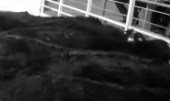

End View


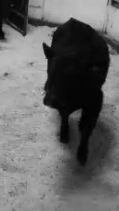

Weight: 755.0
Side View


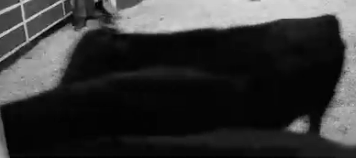

End View


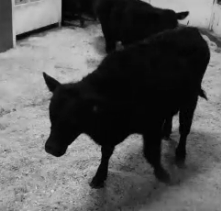

Weight: 755.0
Side View


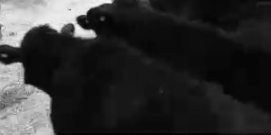

End View


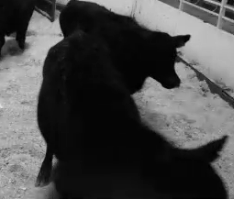

Weight: 578.0
Side View


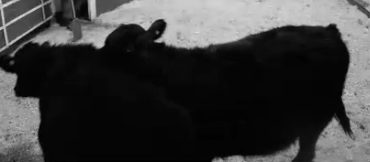

End View


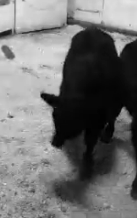

Weight: 578.0
Side View


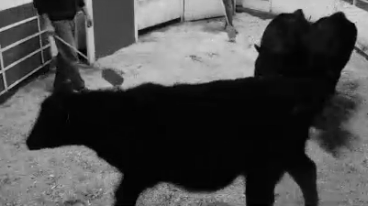

End View


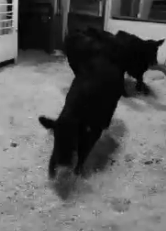

Weight: 578.0
Side View


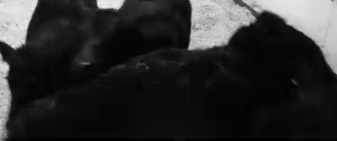

End View


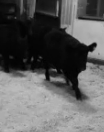

Weight: 578.0
Side View


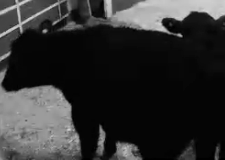

End View


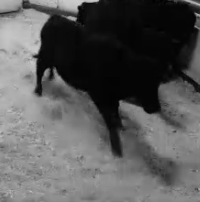

Weight: 578.0
Side View


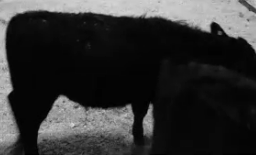

End View


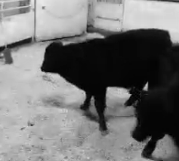

Weight: 578.0
Side View


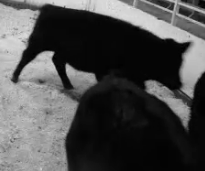

End View


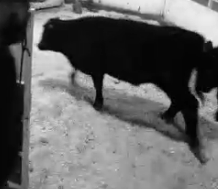

Weight: 664.0
Side View


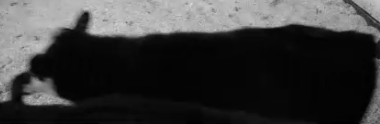

End View


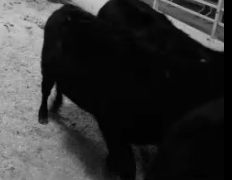

In [76]:
show_cleaned(cleaned[130:140])

### View the Training Data Distribution <a class="anchor" id="saverefined"></a>

<AxesSubplot:title={'center':'Weight Distribution'}>

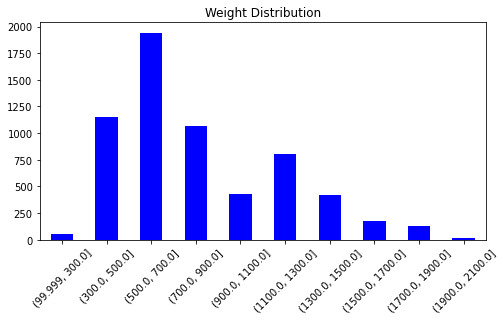

In [120]:
out = pd.cut(cleaned.weight, bins=[100, 300, 500, 700, 900, 1100, 1300, 1500, 1700, 1900, 2100], include_lowest=True)
out.value_counts(sort=False).plot.bar(rot=45, color='b', figsize=(8,4), title='Weight Distribution')

# Functions for handling the dataset <a class="anchor" id="functions"></a>

## Handling Pictures <a class="anchor" id="pictures"></a>
In many cases it is the images within the dataset that we want to work on. This is not a strait-forward process since there is no image processing capabilities in the pandas library and the images are stored outside the pandas frame. 
For these operations we will use the OpenCV library functions and apply them to the dataset with the pandas 'apply()' function. 
This is an efficient way to excecute operations on many images at once. <br>Keep in mind, any image manipulations performed will replace the existing image in the dataset. 

INSTRUCTIONS:
1. Select the data in the pandas frame:
>example: `selected_data = df[df.Avg_Weights > '500']`
2. Apply the desired image function on the IMG_ID column
>example: `selected_data.IMG_ID.apply(bw_img)`


In [ ]:
def bw_img(im_id):
    image = cv2.imread('{}/im_{}.png'.format(INPUT_PATH, im_id))
    grayscale = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('bw/im_{}.png'.format(im_id), grayscale)

In [ ]:
def save_prediction(im_id):
    predictor.predict(in_path='{}/im_{}.png'.format(INPUT_PATH, im_id), out_path='{}/im_{}.png'.format(OUTPUT_PATH, im_id))

In [41]:
def del_img(im_id):
    os.remove('{}/im_{}.png'.format(INPUT_PATH, im_id))

In [314]:
def has_cow(im_id):

    image = cv2.imread('{}/im_{}.png'.format(INPUT_PATH, im_id))
    
    detections = predictor.predict_cow_info(image=image)

    return len(detections) > 0

In [6]:
# get predicted info from yolo
def cow_info(im_id):
    print(type(im_id))
    image = cv2.imread('{}/im_{}.png'.format(INPUT_PATH, im_id))
    return predictor.predict_cow_info(image=image)

### Assign data to the has_cow column based on the respective images

In [18]:
start = time()
pred = df.IMG_ID.apply(cow_info)
end = time()
print('Runtime: {}'.format(end-start))

Runtime: 17.185526132583618


### Check how many datapoints have images

In [156]:
start = time()
print(len(df[df.IMG_ID.apply(has_image)]))
end = time()
print('Runtime: {}'.format(end-start))
print(len(df))

102838
Runtime: 3.831423044204712
102838


# Exploring the Data <a class="anchor" id="exploring_data"></a>

<AxesSubplot:>

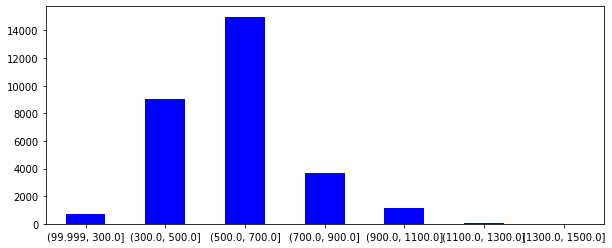

In [51]:
#Look at the distribution 
weights = df[df.Avg_Weight!=''].Avg_Weight.astype({'Avg_Weight':np.int})
out = pd.cut(weights, bins=[100, 300, 500, 700, 900, 1100, 1300, 1500], include_lowest=True)
out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(10,4))


### Show Images in Dataset
This block of code is used when we want to look at a specific sample in the dataset with the images shown along with the prediction overlay. Columns can get in the way of viewing images, so we can drop some of them. 

In [74]:
def prob_cond(pred):
    
    if len(pred) >= 1:

        if type(pred) == pd.core.frame.DataFrame:
            pred = pred.iloc[0]
        #print(pred)
        
        if float(pred['Prob']) < 0.1:
            return True
        else:
            return False
    else:
        return False
temp_df = dataframe[dataframe.prediction.apply(prob_cond)]

In [75]:
#temp_df = df[(df.auction=='beaverlodge') & (df.num_cows==200) & (df.predicted_num_cows==400)][:50].drop(columns=['auction','Type', 'Timestamp', 'Tot_Weight','Shrink', 'Age', 'Hauled', 'Weaned', 'Feed', 'Health']).copy()
#temp_df = temp_df[100:200]

def get_thumbnail(path):
    #i = PIL.Image.open(path, mode='r')  
    img = cv2.imread(path)
    #img = predictor.predict_cow_and_draw(img)
    i = PIL.Image.fromarray(img[:,:,::-1])
    return i

import base64
def image_base64(im):
    if isinstance(im, str):
        im = get_thumbnail(im)
    with BytesIO() as buffer:
        im.save(buffer, 'png')
        return base64.b64encode(buffer.getvalue()).decode()

def image_formatter(im):
    return f'<img src="data:image/jpeg;base64,{image_base64(im)}">'

temp_df['imagePILL'] = temp_df.path.map(lambda f: get_thumbnail(f))
HTML(temp_df.to_html(formatters={'imagePILL': image_formatter}, escape=False))   

<ipython-input-75-55e1a130411f>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_df['imagePILL'] = temp_df.path.map(lambda f: get_thumbnail(f))


HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></…